In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/btc-data/btc_data.pkl


In [38]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression,Ridge,ElasticNet,SGDRegressor,Lasso
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import scipy as sp
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR,LinearSVR
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate

In [39]:
data = pd.read_pickle("/kaggle/input/btc-data/btc_data.pkl")
cols_to_del = ['limit_up_price','limit_down_price','source','volume','instrument_id',"instrument_digital_id",'turnover','type',"open_interst","last_price"]
data.drop(columns=cols_to_del,axis=1,inplace=True)
#Calculating Spread and other features
data['spread'] = data['ask_prices1'] - data['bid_prices1']
#find mid
data['mid'] = (data['bid_prices1'] + data['ask_prices1'])/2
data['mid_change'] = data.mid.diff()
data['return'] = data['spread']/data['mid']
data['Volume_Order_Imbalance'] = data['bid_size1']/(data['bid_size1'] + data['ask_size1'])
data['BA_size_spread'] = data['ask_size1'] - data['bid_size1']
#converting unix timestamp to pandas timestamp
data.machine_time_stamp = pd.to_datetime(data.machine_time_stamp, unit='ns')
data.exchange_time_stamp = pd.to_datetime(data.exchange_time_stamp, unit='ns')
#resampling to 1 s
df = data.resample("1s",on="machine_time_stamp")[['bid_prices1','ask_prices1','bid_size1','ask_size1','spread','mid','return','Volume_Order_Imbalance','BA_size_spread']].mean()
df.fillna(method='ffill',inplace=True)
df['return_10s'] = df['return'].shift(-10)
mid_change_df = data.resample("1s",on="machine_time_stamp")['mid_change'].sum()
df = df.merge(mid_change_df,left_index=True,right_index=True)
df.dropna(inplace=True)
target = 'return_10s'
X = df.drop('return_10s',axis=1)
y = df[target]
#scaling features with min max scaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.index = X.index
df_scaled = X_scaled.merge(y,left_index=True,right_index=True)

In [40]:
df['return_10s'].equals(df_scaled.return_10s)

True

Plotting Distribution of Target and Features

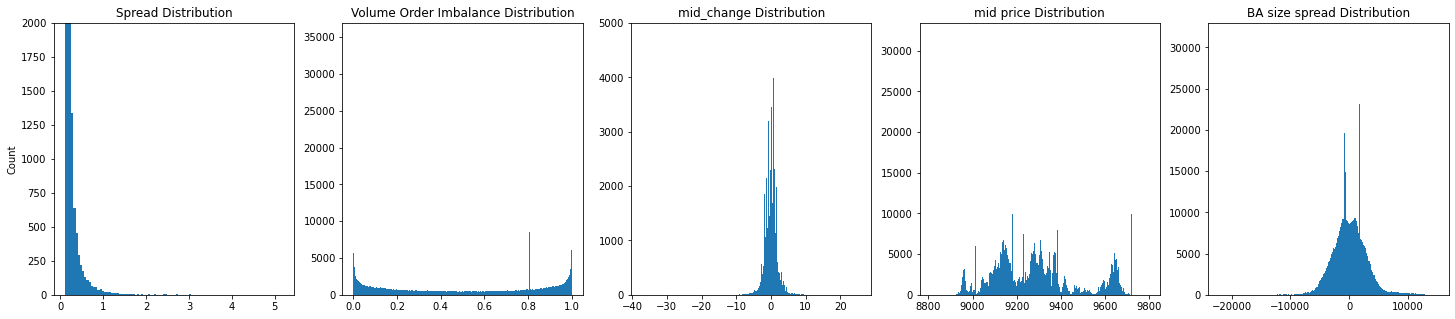

In [41]:
f, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1, 5,figsize=(25,5))
n, bins, patches=ax1.hist(df["spread"],bins=100)
n, bins, patches=ax2.hist(df["Volume_Order_Imbalance"],bins=1000)
n, bins, patches=ax3.hist(df["mid_change"],bins=500)
n, bins, patches=ax4.hist(df["mid"],bins=500)
n, bins, patches=ax5.hist(df["BA_size_spread"],bins=500)
ax1.set_ylim(0,2000)
ax1.set_title('Spread Distribution')
ax1.set_ylabel('Count')
ax2.set_title('Volume Order Imbalance Distribution')
ax3.set_ylim(0,5000)
ax3.set_title('mid_change Distribution')
ax4.set_title('mid price Distribution')
ax5.set_title('BA size spread Distribution')
plt.show()

Split train dev test

In [42]:
#split train test data
#train_size = int(len(df)*0.8)
#test_size = len(df) - train_size
#train_df = df[0:train_size]
#test_df = df[train_size:]
train,dev_test = train_test_split(df_scaled,test_size=0.3,random_state=20)
dev,test = train_test_split(dev_test,test_size=0.5,random_state=2)

<AxesSubplot:xlabel='machine_time_stamp'>

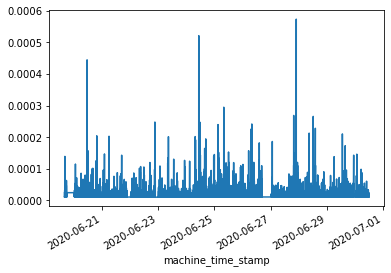

In [43]:
train.return_10s.plot()

<AxesSubplot:xlabel='machine_time_stamp'>

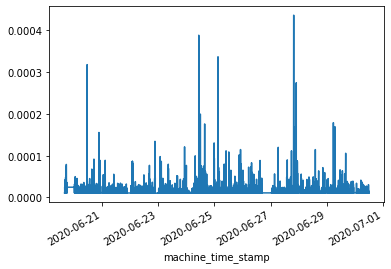

In [44]:
dev.return_10s.plot()

<AxesSubplot:xlabel='machine_time_stamp'>

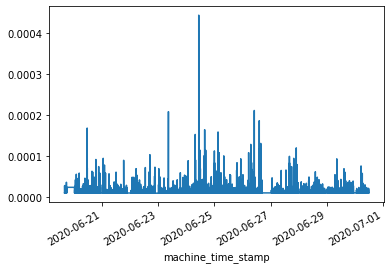

In [45]:
test.return_10s.plot()

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


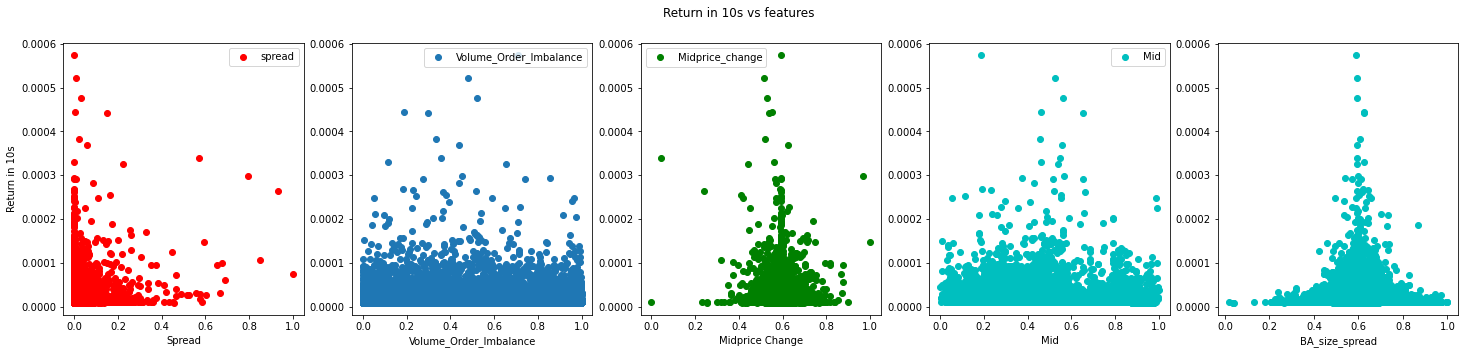

In [46]:
f, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1, 5,figsize=(25,5))
ax1.scatter(x=train.spread,y=train.return_10s,c='r',label="spread")
ax2.scatter(x=train['Volume_Order_Imbalance'],y=train.return_10s,label="Volume_Order_Imbalance")
ax3.scatter(x=train['mid_change'],y=train.return_10s,label="Midprice_change",c="green")
ax4.scatter(x=train['mid'],y=train.return_10s,label="Mid",c="c")
ax5.scatter(x=train['BA_size_spread'],y=train.return_10s,label="Mid",c="c")
ax1.set_ylabel('Return in 10s')
ax1.set_xlabel('Spread')
ax2.set_xlabel('Volume_Order_Imbalance')
ax3.set_xlabel('Midprice Change')
ax4.set_xlabel('Mid')
ax5.set_xlabel("BA_size_spread")
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
f.suptitle("Return in 10s vs features")
plt.show()

Feature Selection

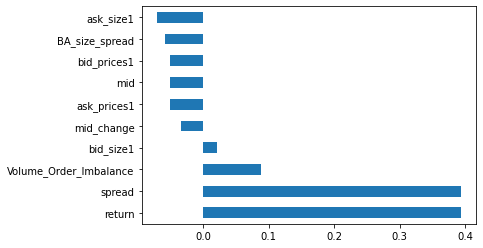

In [47]:
#Feature Selection with correlation
df_corr_health = df.corr()['return_10s'].sort_values(ascending=False)[1:]
top_corr_features = df_corr_health.index
# plot top 20 most correlated features to our target (HEALTH)
df_corr_health.plot(kind='barh')
plt.show()

In [55]:
df.corr().return_10s.sort_values()

ask_size1                -0.070833
BA_size_spread           -0.058007
bid_prices1              -0.051153
mid                      -0.051112
ask_prices1              -0.051070
mid_change               -0.033944
bid_size1                 0.020371
Volume_Order_Imbalance    0.088915
spread                    0.393378
return                    0.393951
return_10s                1.000000
Name: return_10s, dtype: float64

In [48]:
#Feature Selection with Tree Based Regressor
#rf_model = RandomForestRegressor()
#rf_model.fit(train.drop('return_10s',axis=1),train.return_10s)

In [49]:
#feat_importances = pd.Series(rf_model.feature_importances_, index=train.drop('return_10s',axis=1).columns)
#feat_importances.sort_values(ascending=False,inplace=True)
#feat_importances.plot(kind='barh')

In [56]:
# bid_size1, ask_size1, BA_size_spread are highly correlated with Volume_Order_Imbalance
# Thus only pick Volume_Order_Imbalance to prevent overfitting
feature_cols = ['Volume_Order_Imbalance','mid_change','mid','spread']
target_col = "return_10s"

Modelling

In [57]:
train_y = train[target_col].to_numpy()
dev_y = dev[target_col].to_numpy()
test_y = test[target_col].to_numpy()
train_X = train[feature_cols]
dev_X = dev[feature_cols]
test_X = test[feature_cols]

Building Baseline Model with Linear Regression

Using Pearson correlation coefficient, KS test p value, MSE as a performance metric, R2

In [58]:
baseline = LinearRegression().fit(train_X,train_y)
baseline_dev_result = baseline.predict(dev_X)

--------------------Train Result----------------------
Pearson correlation coefficient of baseline model :  0.3983005396031898
R2 Score :  0.1586433198481909
Mean Squared Error of baseline model :  1.587926692733379e-11
******************************************************
--------------------Dev Result----------------------
Pearson correlation coefficient of baseline model :  0.3815177615263161
R2 Score :  0.14551856428138588
Mean Squared Error of baseline model :  1.835156865591619e-11


Text(0.5, 1.0, 'Baseline Result and Ground Truth DEV')

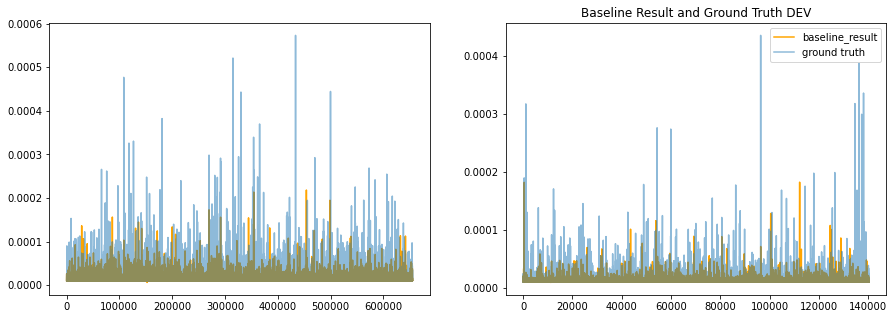

In [59]:
train_pred = baseline.predict(train_X)
res_corr,p = sp.stats.pearsonr(train_y,train_pred)
print("--------------------Train Result----------------------")
print("Pearson correlation coefficient of baseline model : ",res_corr)
print("R2 Score : ",r2_score(train_y,train_pred))
# using MSE score as a metric
print("Mean Squared Error of baseline model : ",mean_squared_error(train_y,train_pred))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(train_pred,label='train_result',alpha=1,c='orange')
ax1.plot(train_y,label="ground truth",alpha=0.5)
plt.title('Baseline Result and Ground Truth TRAIN')
print("******************************************************")
res_corr,p = sp.stats.pearsonr(baseline_dev_result,dev_y)
print("--------------------Dev Result----------------------")
print("Pearson correlation coefficient of baseline model : ",res_corr)
print("R2 Score : ",r2_score(dev_y,baseline_dev_result))
# using MSE score as a metric
print("Mean Squared Error of baseline model : ",mean_squared_error(dev_y,baseline_dev_result))
plt.plot(baseline_dev_result,label='baseline_result',alpha=1,c='orange')
plt.plot(dev_y,label="ground truth",alpha=0.5)
plt.legend()
plt.title('Baseline Result and Ground Truth DEV')

Building Baseline Random Forest Regressor

In [60]:
"""
rf_model = RandomForestRegressor()
rf_model.fit(train_X,train_y)
"""

'\nrf_model = RandomForestRegressor()\nrf_model.fit(train_X,train_y)\n'

In [61]:
"""
filename = 'baseline_rf.sav'
pickle.dump(rf_model, open(filename, 'wb'))
"""

"\nfilename = 'baseline_rf.sav'\npickle.dump(rf_model, open(filename, 'wb'))\n"

In [62]:
"""
train_pred = rf_model.predict(train_X)
res_corr,p = sp.stats.pearsonr(train_y,train_pred)
print("--------------------Train Result----------------------")
print("Pearson correlation coefficient of rf model : ",res_corr)
print("R2 Score : ",r2_score(train_y,train_pred))
# using MSE score as a metric
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
print("Mean Squared Error of rf model : ",mean_squared_error(train_y,train_pred))
ax1.plot(train_pred,label='train_result',alpha=1,c='orange')
ax1.plot(train_y,label="ground truth",alpha=0.5)
ax1.set_title('Random Forest Result and Ground Truth TRAIN')
#use Pearson correlation coefficien as a metric
print("******************************************************")
print("--------------------Dev Result----------------------")
res_corr,p = sp.stats.pearsonr(rf_model.predict(dev_X),dev_y)
print("Pearson correlation coefficient of baseline RF Regressor (DEV) : ",res_corr)
print("R2 Score : ",r2_score(dev_y,rf_model.predict(dev_X)))
# using MSE score as a metric
print("Mean Squared Error of baseline RF Regressor (DEV) : ",mean_squared_error(dev_y,rf_model.predict(dev_X)))

ax2.plot(rf_model.predict(dev_X),label='baseline_rf_result (DEV)',alpha=1,c='orange')
ax2.plot(dev_y,label="ground truth",alpha=0.5)
ax2.legend()
ax2.set_title('Random Forest Result and Ground Truth DEV')
"""

'\ntrain_pred = rf_model.predict(train_X)\nres_corr,p = sp.stats.pearsonr(train_y,train_pred)\nprint("--------------------Train Result----------------------")\nprint("Pearson correlation coefficient of rf model : ",res_corr)\nprint("R2 Score : ",r2_score(train_y,train_pred))\n# using MSE score as a metric\nf, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))\nprint("Mean Squared Error of rf model : ",mean_squared_error(train_y,train_pred))\nax1.plot(train_pred,label=\'train_result\',alpha=1,c=\'orange\')\nax1.plot(train_y,label="ground truth",alpha=0.5)\nax1.set_title(\'Random Forest Result and Ground Truth TRAIN\')\n#use Pearson correlation coefficien as a metric\nprint("******************************************************")\nprint("--------------------Dev Result----------------------")\nres_corr,p = sp.stats.pearsonr(rf_model.predict(dev_X),dev_y)\nprint("Pearson correlation coefficient of baseline RF Regressor (DEV) : ",res_corr)\nprint("R2 Score : ",r2_score(dev_y,rf_model.predict(d

Other Regressors such as Elastic Net, LinearSVR underoperform compare to baseline so these models are not under consideration

Building XGB Regressor

In [63]:
"""
xgb_model = xgb.XGBRegressor()
xgb_model.fit(train_X,train_y)
"""

'\nxgb_model = xgb.XGBRegressor()\nxgb_model.fit(train_X,train_y)\n'

In [64]:
"""
train_pred = xgb_model.predict(train_X)
res_corr,p = sp.stats.pearsonr(train_y,train_pred)
print("--------------------Train Result----------------------")
print("Pearson correlation coefficient of rf model : ",res_corr)
print("R2 Score : ",r2_score(train_y,train_pred))
# using MSE score as a metric
print("Mean Squared Error of rf model : ",mean_squared_error(train_y,train_pred))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(train_pred,label='train_result',alpha=1,c='orange')
ax1.plot(train_y,label="ground truth",alpha=0.5)
ax1.set_title('XGB Result and Ground Truth TRAIN')
xgb_corr,p = sp.stats.pearsonr(xgb_model.predict(dev_X),dev_y)
print("*****************************************************")
print("--------------------Dev Result----------------------")
print("Pearson correlation coefficient of baseline xgb (DEV): ",xgb_corr)
print("R2 Score : ",r2_score(dev_y,xgb_model.predict(dev_X)))
# using MSE score as a metric
print("Mean Squared Error of baseline xgb (DEV): ",mean_squared_error(xgb_model.predict(dev_X),dev_y))
ax2.plot(xgb_model.predict(dev_X),label='baseline_xgb_result (DEV)',alpha=1,c='orange')
ax2.plot(dev_y,label="ground truth",alpha=0.5)
ax2.legend()
ax2.set_title('XGB Result and Ground Truth DEV')
"""

'\ntrain_pred = xgb_model.predict(train_X)\nres_corr,p = sp.stats.pearsonr(train_y,train_pred)\nprint("--------------------Train Result----------------------")\nprint("Pearson correlation coefficient of rf model : ",res_corr)\nprint("R2 Score : ",r2_score(train_y,train_pred))\n# using MSE score as a metric\nprint("Mean Squared Error of rf model : ",mean_squared_error(train_y,train_pred))\nf, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))\nax1.plot(train_pred,label=\'train_result\',alpha=1,c=\'orange\')\nax1.plot(train_y,label="ground truth",alpha=0.5)\nax1.set_title(\'XGB Result and Ground Truth TRAIN\')\nxgb_corr,p = sp.stats.pearsonr(xgb_model.predict(dev_X),dev_y)\nprint("*****************************************************")\nprint("--------------------Dev Result----------------------")\nprint("Pearson correlation coefficient of baseline xgb (DEV): ",xgb_corr)\nprint("R2 Score : ",r2_score(dev_y,xgb_model.predict(dev_X)))\n# using MSE score as a metric\nprint("Mean Squared Error o

In [65]:
"""
lgbm = LGBMRegressor()
lgbm.fit(train_X,train_y)
"""

'\nlgbm = LGBMRegressor()\nlgbm.fit(train_X,train_y)\n'

In [66]:
"""
train_pred = lgbm.predict(train_X)
res_corr,p = sp.stats.pearsonr(train_y,train_pred)
print("--------------------Train Result----------------------")
print("Pearson correlation coefficient of rf model : ",res_corr)
print("R2 Score : ",r2_score(train_y,train_pred))
# using MSE score as a metric
print("Mean Squared Error of rf model : ",mean_squared_error(train_y,train_pred))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(train_pred,label='train_result',alpha=1,c='orange')
ax1.plot(train_y,label="ground truth",alpha=0.5)
ax1.set_title('LGBM Result and Ground Truth TRAIN')
lgbm_corr,p = sp.stats.pearsonr(lgbm.predict(dev_X),dev_y)
print("*****************************************************")
print("--------------------Dev Result----------------------")
print("Pearson correlation coefficient of baseline LGBM (DEV): ",lgbm_corr)
print("R2 Score : ",r2_score(dev_y,lgbm.predict(dev_X)))
# using MSE score as a metric
print("Mean Squared Error of baseline lgbm (DEV): ",mean_squared_error(lgbm.predict(dev_X),dev_y))
ax2.plot(lgbm.predict(dev_X),label='baseline_lgbm_result (DEV)',alpha=1,c='orange')
ax2.plot(dev_y,label="ground truth",alpha=0.5)
ax2.legend()
ax2.set_title('LGBM Result and Ground Truth DEV')
"""

'\ntrain_pred = lgbm.predict(train_X)\nres_corr,p = sp.stats.pearsonr(train_y,train_pred)\nprint("--------------------Train Result----------------------")\nprint("Pearson correlation coefficient of rf model : ",res_corr)\nprint("R2 Score : ",r2_score(train_y,train_pred))\n# using MSE score as a metric\nprint("Mean Squared Error of rf model : ",mean_squared_error(train_y,train_pred))\nf, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))\nax1.plot(train_pred,label=\'train_result\',alpha=1,c=\'orange\')\nax1.plot(train_y,label="ground truth",alpha=0.5)\nax1.set_title(\'LGBM Result and Ground Truth TRAIN\')\nlgbm_corr,p = sp.stats.pearsonr(lgbm.predict(dev_X),dev_y)\nprint("*****************************************************")\nprint("--------------------Dev Result----------------------")\nprint("Pearson correlation coefficient of baseline LGBM (DEV): ",lgbm_corr)\nprint("R2 Score : ",r2_score(dev_y,lgbm.predict(dev_X)))\n# using MSE score as a metric\nprint("Mean Squared Error of baseline 

Out of all these models, XGBOOST and LIGHTGMB outperform others but LIGHTGBM is quicker to train show less degrees of overfitting and higher ability to generalise. Thus I decide to go ahead with LIGHTGBM

Hyperparameter Tuning

As LIGHGBM are quick to train, I am going to use random search CV to tune hyperparameter

In [67]:
#df_cv = pd.concat([train,dev])

In [68]:
#cv_X = df_cv[feature_cols].to_numpy()
#cv_y = df_cv[target_col].to_numpy()

In [69]:
#regres = LGBMRegressor()

In [70]:
#scores = cross_validate(regres, cv_X, cv_y, cv=4,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)#

In [71]:
#print(scores['test_neg_mean_squared_error'].mean()*-1)
#print(scores['test_r2'].mean())

NameError: name 'scores' is not defined

In [72]:
params = {} #initialize parameters
params['learning_rate'] = [0.2]
params['num_leaves'] = np.linspace(70,100,4,dtype=int)
params['max_depth'] = [4]
params['boosting_type']=['dart']
params["min_child_samples"] = np.linspace(105,110,2,dtype=int)

In [73]:
params

{'learning_rate': [0.2],
 'num_leaves': array([ 70,  80,  90, 100]),
 'max_depth': [4],
 'boosting_type': ['dart'],
 'min_child_samples': array([105, 110])}

In [74]:
#clf = RandomizedSearchCV(regres,params,n_iter=10,scoring='r2',return_train_score=True,cv=4,refit='r2',verbose=2,random_state=42)

In [75]:
#search = clf.fit(cv_X, cv_y)

In [76]:
#search.best_params_

In [77]:
#search.best_params_

In [78]:
#search.best_params_

In [79]:
#search.best_score_

In [80]:
optimal_lgbm = LGBMRegressor(num_leaves= 70,
 min_child_samples=105,
 max_depth=4,
 learning_rate= 0.2,
 boosting_type='dart')

In [81]:
"""
optimal_lgbm.fit(train_X,train_y)
"""

'\noptimal_lgbm.fit(train_X,train_y)\n'

In [82]:
"""
dev_result=optimal_lgbm.predict(dev_X)
lgbm_corr,p = sp.stats.pearsonr(dev_result,dev_y)
print("--------------------Dev Result----------------------")
print("Pearson correlation coefficient of baseline LGBM (DEV): ",lgbm_corr)
print("R2 Score : ",r2_score(dev_y,optimal_lgbm.predict(dev_X)))
# using MSE score as a metric
print("Mean Squared Error of baseline lgbm (DEV): ",mean_squared_error(lgbm.predict(dev_X),dev_y))
plt.plot(lgbm.predict(dev_X),label='baseline_lgbm_result (DEV)',alpha=1,c='orange')
plt.plot(dev_y,label="ground truth",alpha=0.5)
plt.legend()
plt.title('LGBM Result and Ground Truth DEV')
"""

'\ndev_result=optimal_lgbm.predict(dev_X)\nlgbm_corr,p = sp.stats.pearsonr(dev_result,dev_y)\nprint("--------------------Dev Result----------------------")\nprint("Pearson correlation coefficient of baseline LGBM (DEV): ",lgbm_corr)\nprint("R2 Score : ",r2_score(dev_y,optimal_lgbm.predict(dev_X)))\n# using MSE score as a metric\nprint("Mean Squared Error of baseline lgbm (DEV): ",mean_squared_error(lgbm.predict(dev_X),dev_y))\nplt.plot(lgbm.predict(dev_X),label=\'baseline_lgbm_result (DEV)\',alpha=1,c=\'orange\')\nplt.plot(dev_y,label="ground truth",alpha=0.5)\nplt.legend()\nplt.title(\'LGBM Result and Ground Truth DEV\')\n'

In [83]:
#train model with both dev and train data
#optimal_lgbm.fit(cv_X,cv_y)

In [84]:
"""
train_result=optimal_lgbm.predict(cv_X)
opt_lgbm_corr,p = sp.stats.pearsonr(train_result,cv_y)
print("*****************************************************")
print("--------------------Train Result----------------------")
print("Pearson correlation coefficient of Optimised LGBM: ",opt_lgbm_corr)
print("R2 Score : ",r2_score(cv_y,train_result))
plt.plot(train_result,label='optimised_lgbm_result (TRAIN)',alpha=1,c='orange')
plt.plot(cv_y,label="ground truth",alpha=0.5)
plt.legend()
plt.title('LGBM Result and Ground Truth TRAIN')
"""

'\ntrain_result=optimal_lgbm.predict(cv_X)\nopt_lgbm_corr,p = sp.stats.pearsonr(train_result,cv_y)\nprint("*****************************************************")\nprint("--------------------Train Result----------------------")\nprint("Pearson correlation coefficient of Optimised LGBM: ",opt_lgbm_corr)\nprint("R2 Score : ",r2_score(cv_y,train_result))\nplt.plot(train_result,label=\'optimised_lgbm_result (TRAIN)\',alpha=1,c=\'orange\')\nplt.plot(cv_y,label="ground truth",alpha=0.5)\nplt.legend()\nplt.title(\'LGBM Result and Ground Truth TRAIN\')\n'

In [86]:
"""
test_result=optimal_lgbm.predict(test_X)
opt_lgbm_corr,p = sp.stats.pearsonr(test_result,test_y)
print("*****************************************************")
print("--------------------Test Result----------------------")
print("Pearson correlation coefficient of Optimised LGBM: ",opt_lgbm_corr)
print("R2 Score : ",r2_score(test_y,test_result))
plt.plot(test_result,label='optimised_lgbm_result (TEST)',alpha=1,c='orange')
plt.plot(test_y,label="ground truth",alpha=0.5)
plt.legend()
plt.title('LGBM Result and Ground Truth TEST')
"""

'\ntest_result=optimal_lgbm.predict(test_X)\nopt_lgbm_corr,p = sp.stats.pearsonr(test_result,test_y)\nprint("*****************************************************")\nprint("--------------------Test Result----------------------")\nprint("Pearson correlation coefficient of Optimised LGBM: ",opt_lgbm_corr)\nprint("R2 Score : ",r2_score(test_y,test_result))\nplt.plot(test_result,label=\'optimised_lgbm_result (TEST)\',alpha=1,c=\'orange\')\nplt.plot(test_y,label="ground truth",alpha=0.5)\nplt.legend()\nplt.title(\'LGBM Result and Ground Truth TEST\')\n'

After using different models, I think it would be best to model return_10s using basic Linear Regression due to the fact that, there are useful missing information in that 10s that I cant gain access to. Plus Linear Regression is the simplest model that could capture good value of correlation and a good resemblence of the distribution of returns

--------------------Test Result----------------------
Pearson correlation coefficient of baseline model :  0.44096096770361115
R2 Score :  0.19300635715952918
Mean Squared Error of baseline model :  1.4456919555742372e-11


Text(0.5, 1.0, 'Baseline Result and Ground Truth DEV')

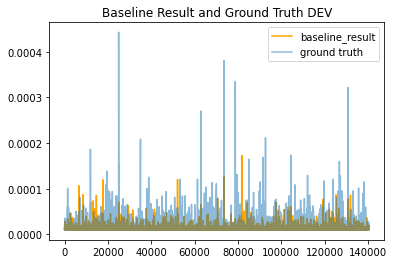

In [87]:
baseline_test_result = baseline.predict(test_X)
res_corr,p = sp.stats.pearsonr(test_y,baseline_test_result)
print("--------------------Test Result----------------------")
print("Pearson correlation coefficient of baseline model : ",res_corr)
print("R2 Score : ",r2_score(test_y,baseline_test_result))
# using MSE score as a metric
print("Mean Squared Error of baseline model : ",mean_squared_error(test_y,baseline_test_result))
plt.plot(baseline_test_result,label='baseline_result',alpha=1,c='orange')
plt.plot(test_y,label="ground truth",alpha=0.5)
plt.legend()
plt.title('Baseline Result and Ground Truth DEV')